# Extracting Vertebrae from MRIs Using Predicted Model Masks
CS3310 : Muftuler Project 1

This notebook explores the extraction of the signals under the predicted vertebrae masks for a patient. Along with this work, signal intensity distributions for a healthy and degenerated spine are explored and compared. 

### Library Imports 

In [1]:
# LTM: uncomment if model or data is too large for GPU memory
import os #LTM
os.environ["CUDA_VISIBLE_DEVICES"] = "-1" #LTM

import sys #LTM

import matplotlib
from matplotlib import pyplot as plt
import numpy as np

from tensorflow import keras, config, debugging
import tensorflow.keras.backend as K #LTM

import nibabel as nib

import SimpleITK as sitk

# from disc.utils.disc_data_multiclass import get_dataset
# from src.utils.spine_data_multiclass import read_nifti_file, get_path_from_root, get_dataset_split, get_data_split_tensorflow, standardize_scans
# from src.utils.metrics import dice_coef

#### Scan Standardization Helper Method

In [2]:
def standardize_scan(X):
    return (X - X.mean()) / X.std()

### Load VOIs

In [3]:
transparent_vois_cmap = matplotlib.colors.ListedColormap(["none", "red"])

test_subject = 'S216'
data_path_216 = '../spine/S216/'

L4_216_path = nib.load(data_path_216 + 'example_vois/L4_vb.nii')
L4_216 = L4_216_path.get_fdata()
L4_216 = np.moveaxis(L4_216, -1, 0)

L4_216.shape

(16, 512, 512)

### Load Patient Scan 

In [4]:
scan_216_path = nib.load(data_path_216 + 's216_T2.nii.gz')
scan_216 = scan_216_path.get_fdata()
scan_216 = np.moveaxis(scan_216, -1, 0)
scan_216 = standardize_scan(scan_216)

scan_216 = K.constant(scan_216.reshape(*scan_216.shape, 1))
scan_216.shape

TensorShape([16, 512, 512, 1])

### Plot Scan with VOI

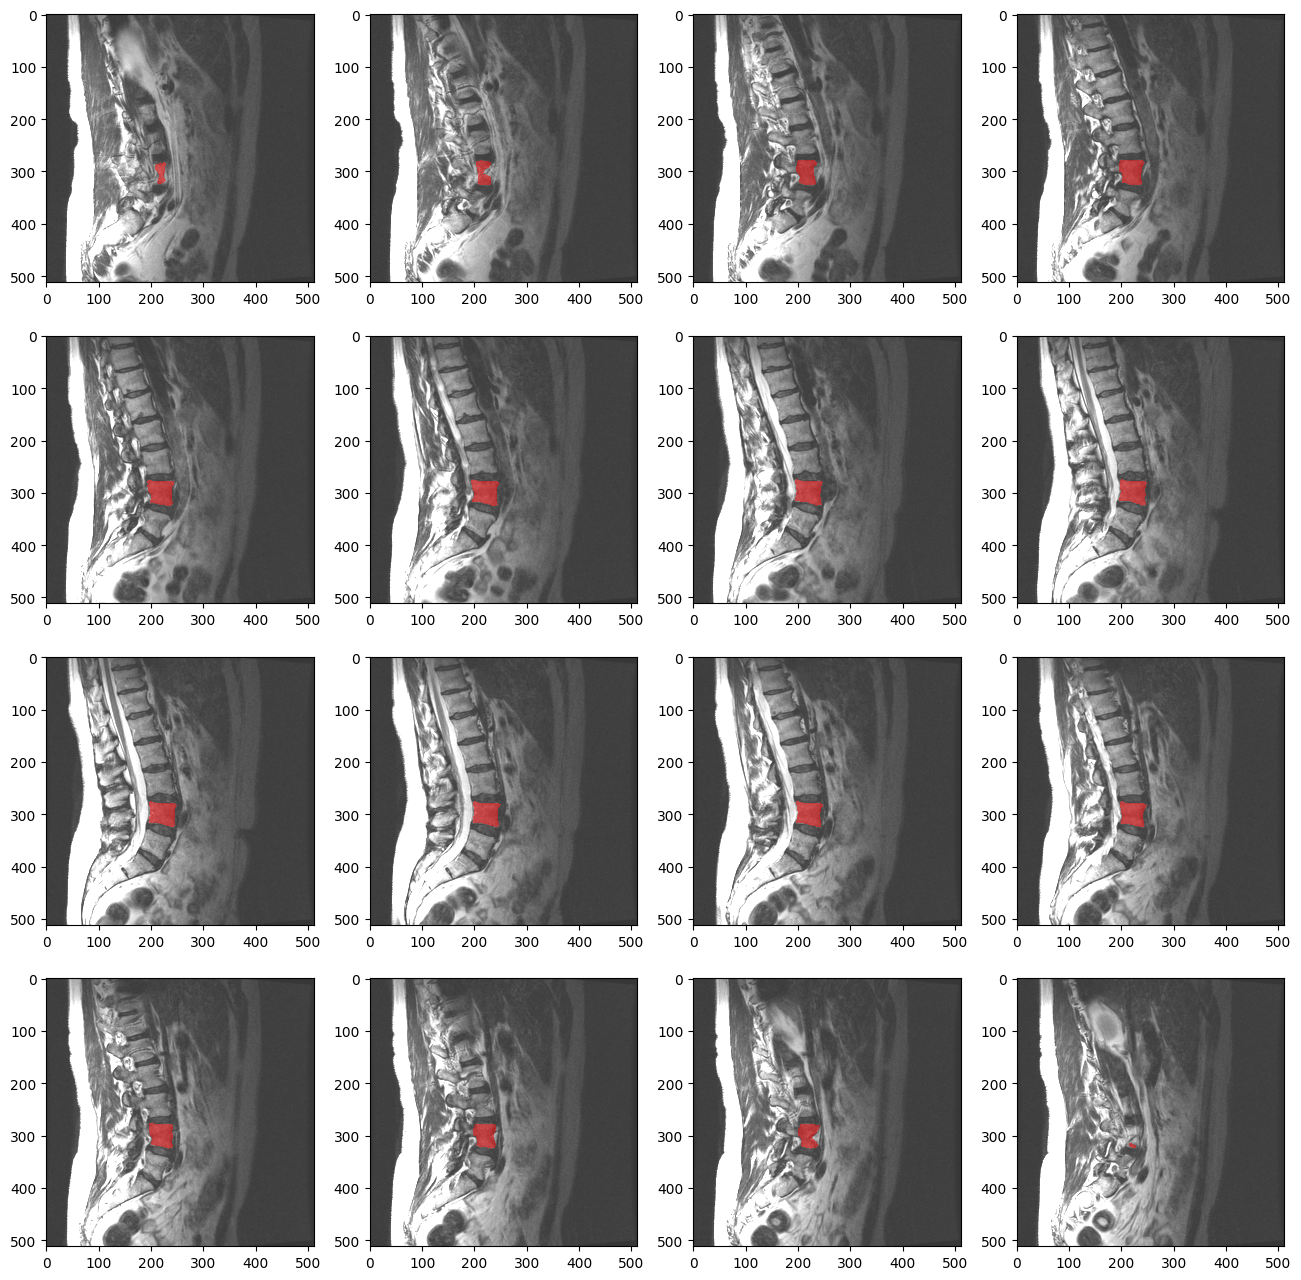

In [5]:
n_slices = scan_216.shape[0]
fig, axs = plt.subplots(n_slices // 4, 4, figsize=(16, n_slices))

for i, ax in zip(range(n_slices), axs.flatten()):
    ax.imshow(np.rot90(scan_216[i,:,:],-1),cmap="gray", vmin=-1, vmax=1) 
    ax.imshow(np.rot90(L4_216[i,:,:],-1), cmap=transparent_vois_cmap, alpha=0.5)

### Isolate Slices 7, 8, 9

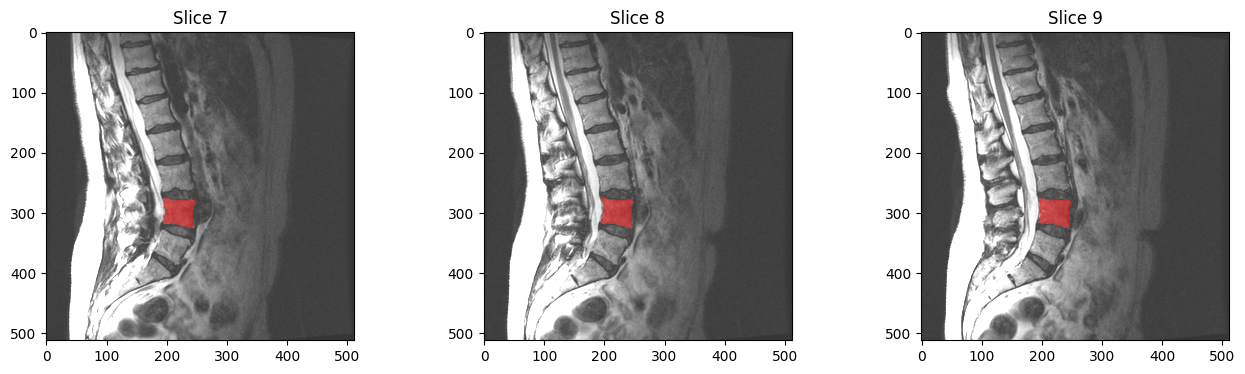

In [6]:
n_slices = scan_216.shape[0]
fig, axs = plt.subplots(1, 3, figsize=(16, n_slices/4))

for i, ax in zip(range(6,9), axs.flatten()):
    ax.imshow(np.rot90(scan_216[i,:,:],-1),cmap="gray", vmin=-1, vmax=1) 
    ax.imshow(np.rot90(L4_216[i,:,:],-1), cmap=transparent_vois_cmap, alpha=0.5)
    ax.set_title("Slice {}".format(i+1)) # accounting for first slice being at 0 so +1

### Read All Vertebrae Masks for S216

Loading the images with SimpleITK makes the following code happy, using nibabel doesn't work 

In [7]:
scan_216 = sitk.ReadImage(data_path_216 + 's216_T2.nii.gz')
T12_216 = sitk.ReadImage(data_path_216 + 'example_vois/T12_vb.nii')
L1_216 = sitk.ReadImage(data_path_216 + 'example_vois/L1_vb.nii')
L2_216 = sitk.ReadImage(data_path_216 + 'example_vois/L2_vb.nii')
L3_216 = sitk.ReadImage(data_path_216 + 'example_vois/L3_vb.nii')
L4_216 = sitk.ReadImage(data_path_216 + 'example_vois/L4_vb.nii')
L5_216 = sitk.ReadImage(data_path_216 + 'example_vois/L5_vb.nii')

vb_masks_216 = {'T12':T12_216, 'L1':L1_216, 'L2':L2_216, 'L3':L3_216, 'L4':L4_216, 'L5':L5_216}

### Plot Signal Distributions for Each Vertebrae

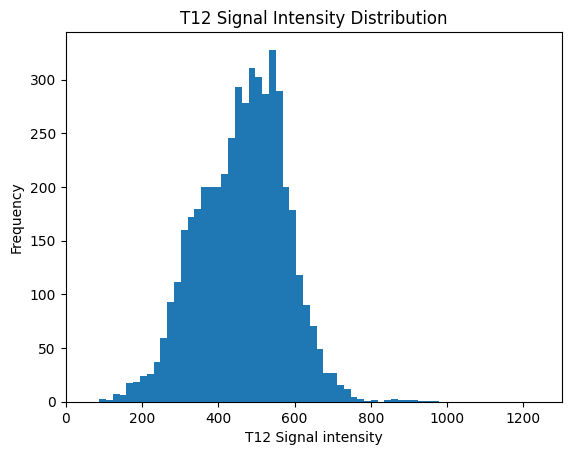

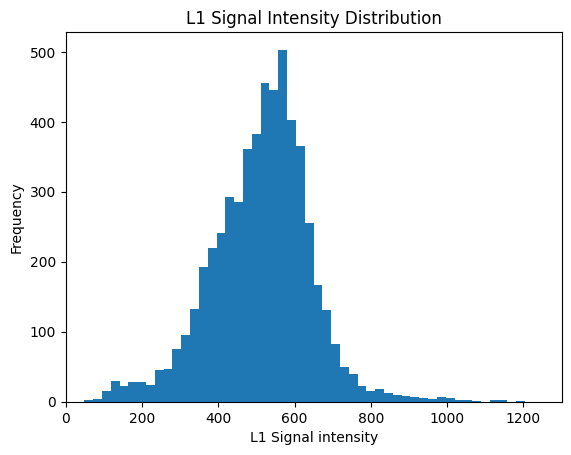

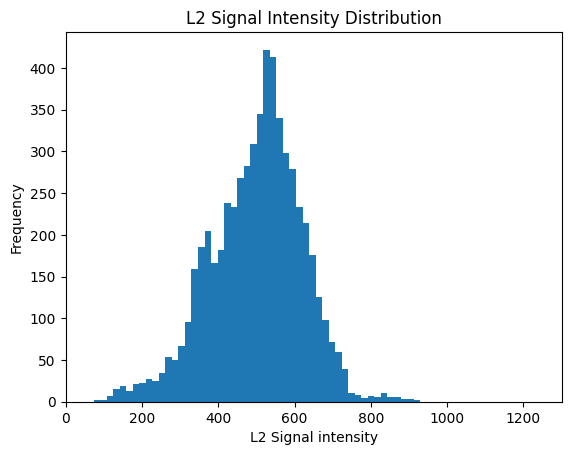

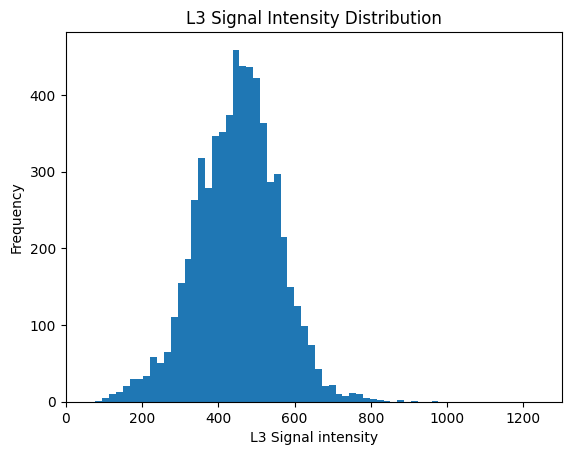

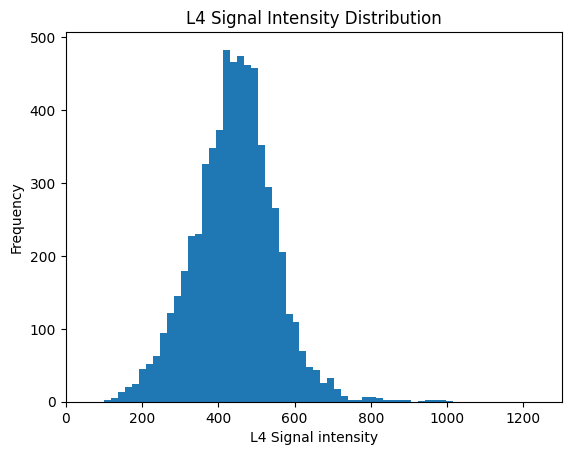

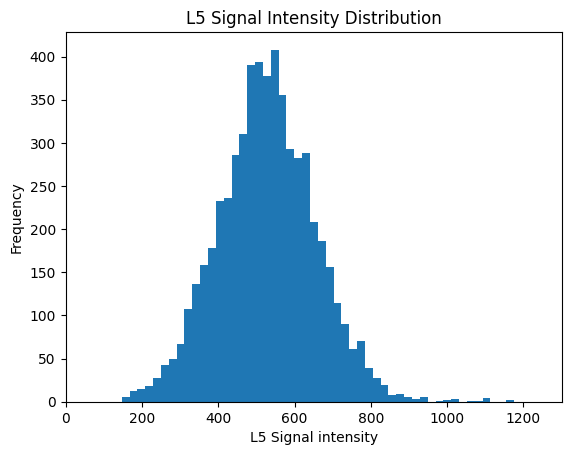

In [8]:
for name, mask in vb_masks_216.items():
    # Get the numpy arrays of the image and mask
    scan_array = sitk.GetArrayFromImage(scan_216)
    mask_array = sitk.GetArrayFromImage(mask)

    # Apply the mask to the image
    masked_image_array = np.ma.masked_array(scan_array[7:10, :, :], np.logical_not(mask_array[7:10, :, :]))

    # Get the signal intensity values within the ROI
    signal_intensities = masked_image_array.compressed()

    # Plot a histogram of the signal intensity values
    fig, ax = plt.subplots()
    ax.hist(signal_intensities, bins=50)
    ax.set(xlim=(0, 1300))
    ax.set_title(f'{name} Signal Intensity Distribution')
    ax.set_xlabel(f'{name} Signal intensity')
    ax.set_ylabel('Frequency')
    plt.show()

### Load Patient 226 (Modic Change Type 2 in L2-L5)

In [9]:
test_subject = 'S226'
data_path_226 = '../spine/S226/'

scan_226 = sitk.ReadImage(data_path_226 + 's226_T2.nii.gz')
# scan_226 = standardize_scan(scan_226)
T12_226 = sitk.ReadImage(data_path_226 + 'vois/T12_vb.nii')
L1_226 = sitk.ReadImage(data_path_226 + 'vois/L1_vb.nii')
L2_226 = sitk.ReadImage(data_path_226 + 'vois/L2_vb.nii')
L3_226 = sitk.ReadImage(data_path_226 + 'vois/L3_vb.nii')
L4_226 = sitk.ReadImage(data_path_226 + 'vois/L4_vb.nii')
L5_226 = sitk.ReadImage(data_path_226 + 'vois/L5_vb.nii')

vb_masks_226 = {'T12':T12_226, 'L1':L1_226, 'L2':L2_226, 'L3':L3_226, 'L4':L4_226, 'L5':L5_226}

### Plot S226 VB Signal Intensity Distributions

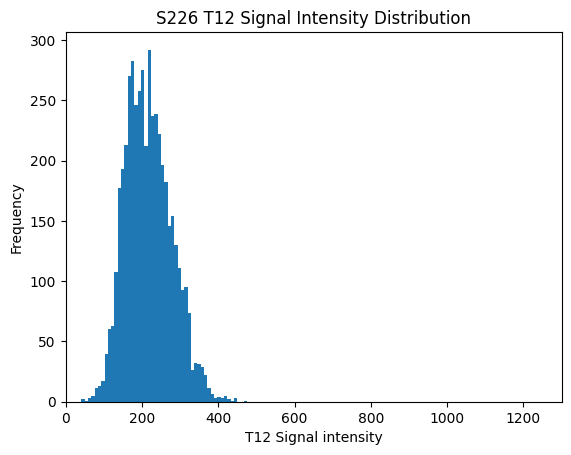

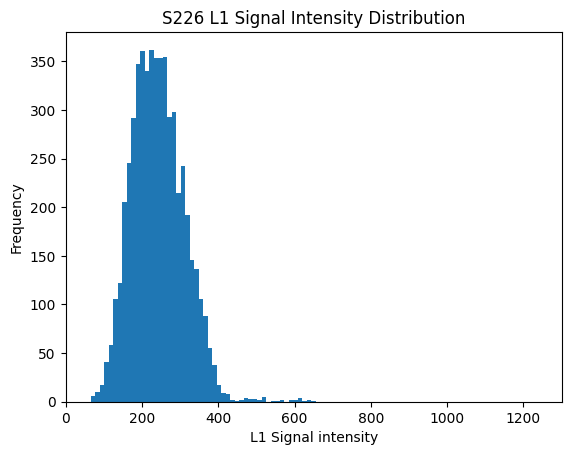

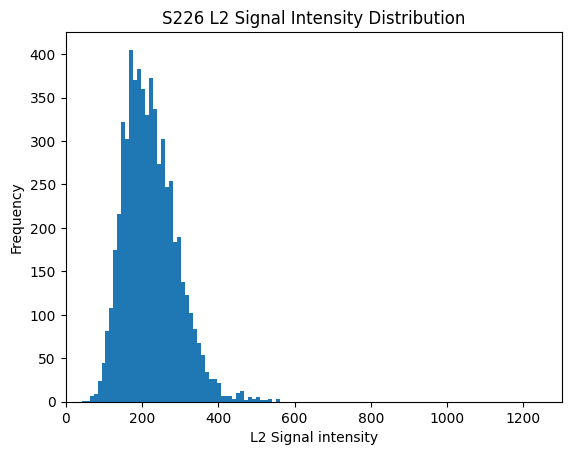

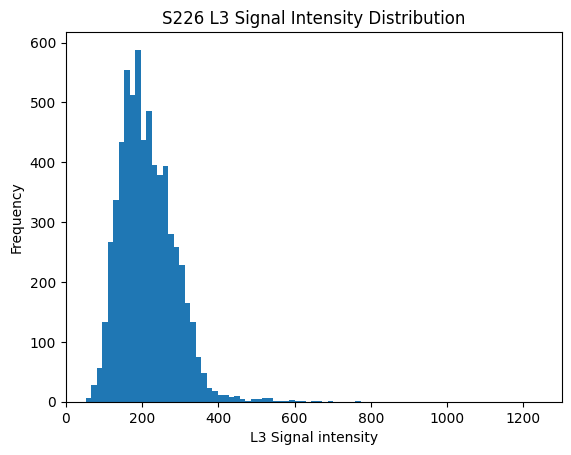

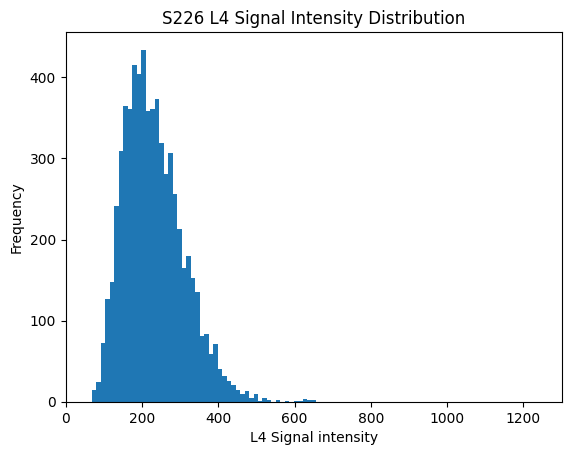

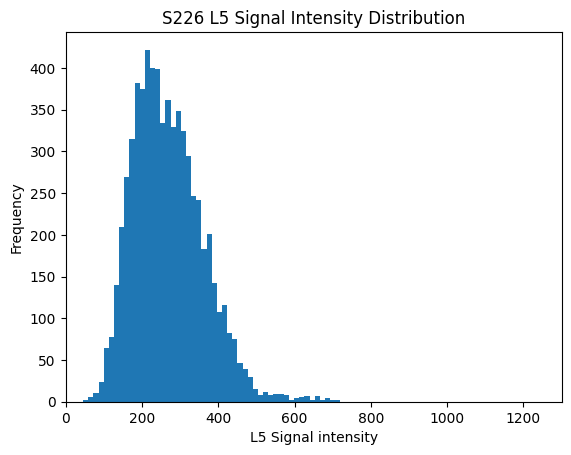

In [10]:
for name, mask in vb_masks_226.items():
    # Get the numpy arrays of the image and mask
    scan_array = sitk.GetArrayFromImage(scan_226)
    mask_array = sitk.GetArrayFromImage(mask)

    # Apply the mask to the image
    masked_image_array = np.ma.masked_array(scan_array[7:10, :, :], np.logical_not(mask_array[7:10, :, :]))

    # Get the signal intensity values within the ROI
    signal_intensities = masked_image_array.compressed()

    # Plot a histogram of the signal intensity values
    fig, ax = plt.subplots()
    ax.hist(signal_intensities, bins=50)
    ax.set(xlim=(0, 1300))
    ax.set_title(f'{test_subject} {name} Signal Intensity Distribution')
    ax.set_xlabel(f'{name} Signal intensity')
    ax.set_ylabel('Frequency')
    plt.show()

### Plot Healthy / Degenerated VB Signal Intensity Distributions

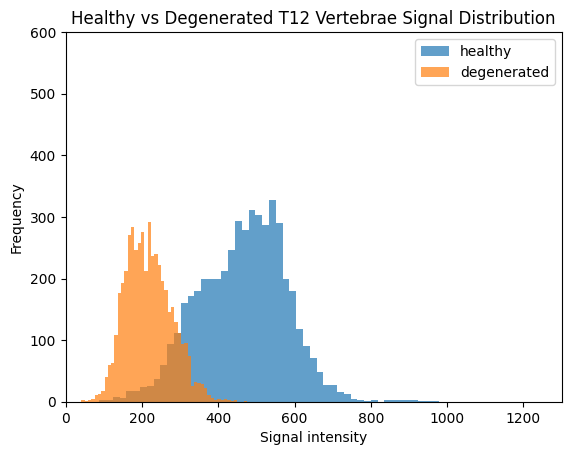

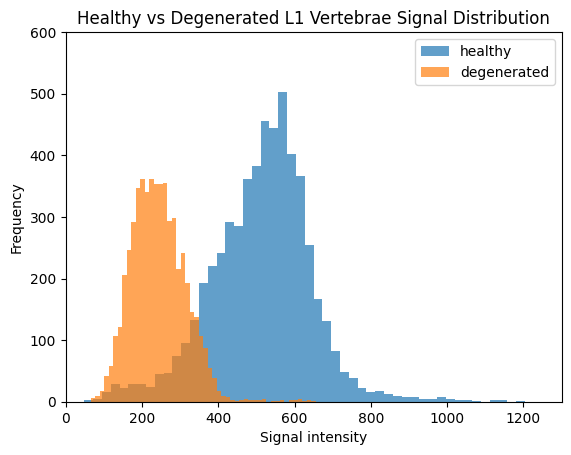

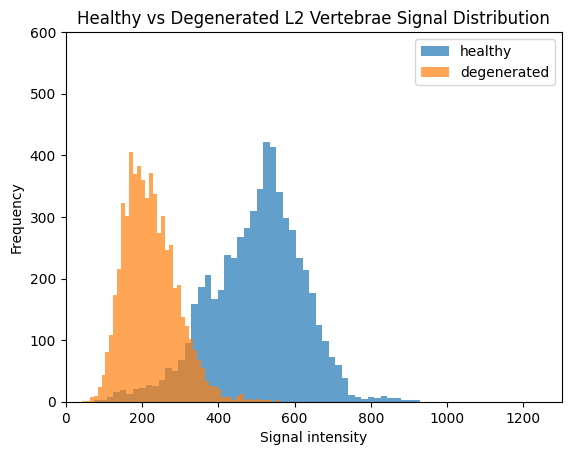

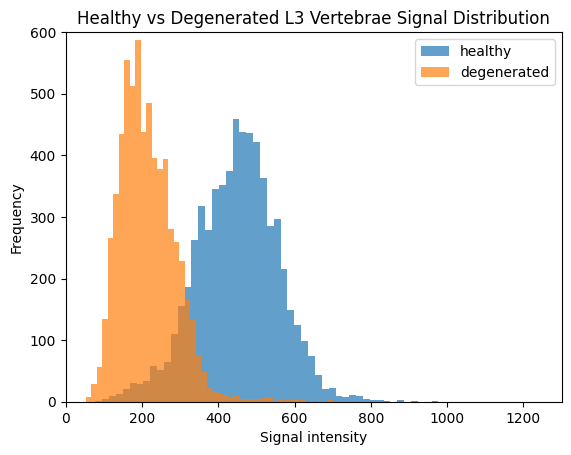

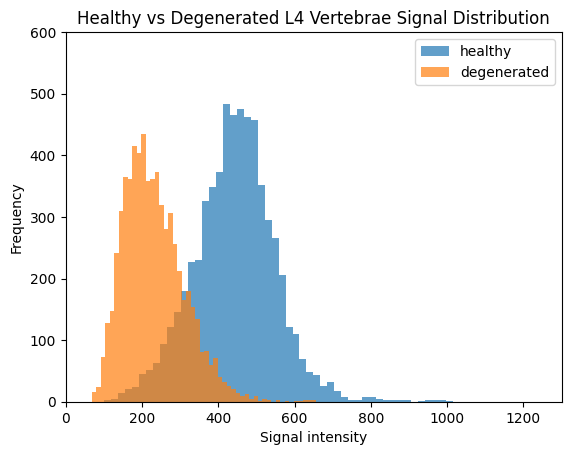

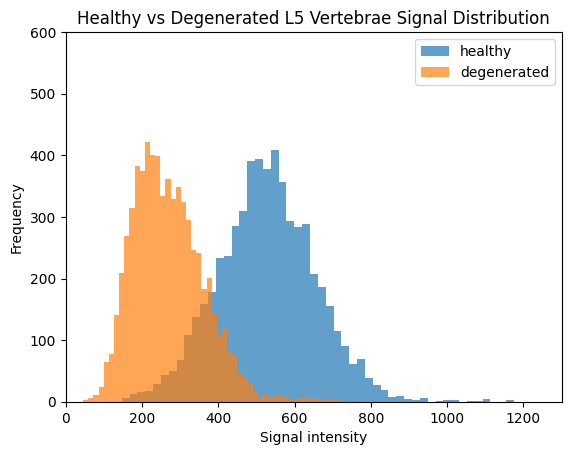

In [11]:
for mask_216, mask_226 in zip(vb_masks_216.items(), vb_masks_226.items()): 
    # Get the numpy arrays of the image and mask 
    image_array = sitk.GetArrayFromImage(scan_216) 
    mask_array = sitk.GetArrayFromImage(mask_216[1]) 
    # Apply the mask to the image 
    masked_image_array = np.ma.masked_array(image_array[7:10,:,:], np.logical_not(mask_array[7:10,:,:])) 
    # Get the signal intensity values within the ROI 
    signal_intensities_216 = masked_image_array.compressed() 
    image_array = sitk.GetArrayFromImage(scan_226) 
    mask_array = sitk.GetArrayFromImage(mask_226[1]) 
    # Apply the mask to the image 
    masked_image_array = np.ma.masked_array(image_array[7:10,:,:], np.logical_not(mask_array[7:10,:,:])) 
    # Get the signal intensity values within the ROI 
    signal_intensities_226 = masked_image_array.compressed() 
    # Plot a histogram of the signal intensity values 
    fig, ax = plt.subplots() 
    ax.hist(signal_intensities_216, bins=50, label='healthy', alpha=0.7) 
    ax.hist(signal_intensities_226, bins=50, label='degenerated', alpha=0.7) 
    ax.set(xlim=(0, 1300), ylim=(0, 600))
    ax.set_title(f'Healthy vs Degenerated {mask_216[0]} Vertebrae Signal Distribution')
    ax.set_xlabel('Signal intensity') 
    ax.set_ylabel('Frequency') 
    ax.legend()
    plt.show()